In [1]:
import nltk
from nltk import FreqDist

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayushi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy
import json

In [4]:
import gensim

from gensim import corpora


In [5]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_json('C:/Users/Ayushi/Desktop/Automotive_5.json', lines=True)

In [7]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,"Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...","07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,"I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...","12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,"I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...","07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


In [8]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

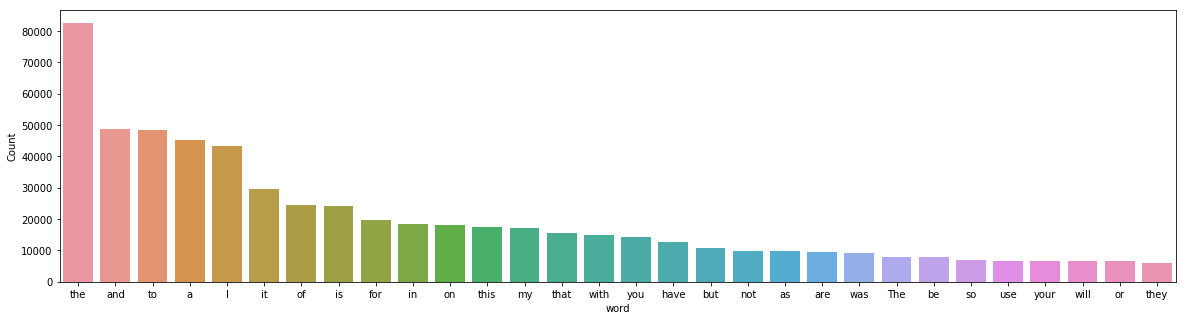

In [9]:
freq_words(df['reviewText'])

In [10]:
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [12]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

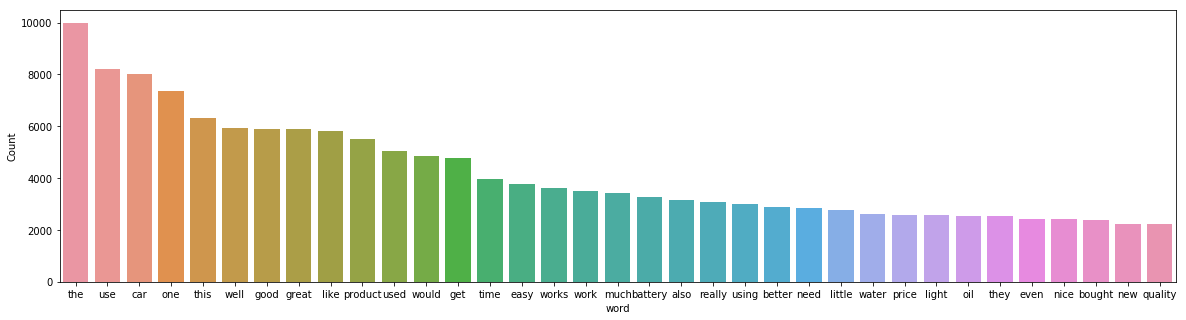

In [13]:
freq_words(reviews, 35)

In [14]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [15]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [16]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'snap', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


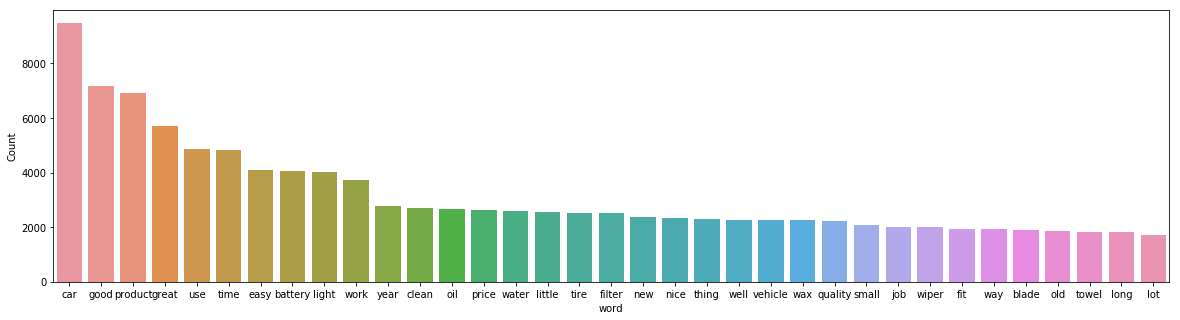

In [17]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

In [18]:
dictionary = corpora.Dictionary(reviews_2)

In [19]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [20]:
lda_model.print_topics()

[(0,
  '0.018*"tire" + 0.014*"use" + 0.013*"good" + 0.012*"easy" + 0.012*"tool" + 0.010*"small" + 0.010*"great" + 0.010*"work" + 0.009*"thing" + 0.008*"nice"'),
 (1,
  '0.031*"wiper" + 0.030*"blade" + 0.015*"hose" + 0.013*"fit" + 0.013*"easy" + 0.013*"good" + 0.010*"part" + 0.010*"water" + 0.010*"old" + 0.010*"install"'),
 (2,
  '0.033*"battery" + 0.028*"car" + 0.015*"oil" + 0.015*"power" + 0.012*"device" + 0.011*"filter" + 0.011*"plug" + 0.010*"unit" + 0.010*"engine" + 0.010*"use"'),
 (3,
  '0.088*"light" + 0.030*"bulb" + 0.022*"bright" + 0.012*"white" + 0.011*"jeep" + 0.010*"great" + 0.008*"color" + 0.008*"night" + 0.007*"good" + 0.007*"wire"'),
 (4,
  '0.028*"product" + 0.021*"leather" + 0.015*"kit" + 0.012*"clean" + 0.011*"surface" + 0.011*"car" + 0.011*"good" + 0.010*"new" + 0.009*"plastic" + 0.008*"black"'),
 (5,
  '0.048*"towel" + 0.031*"car" + 0.025*"water" + 0.014*"window" + 0.012*"glass" + 0.012*"dry" + 0.011*"rain" + 0.010*"windshield" + 0.010*"size" + 0.010*"snow"'),
 (6,
 

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\Ayushi\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\Users\Ayushi\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      19.644295        1       1 -0.010497  0.019323
0      19.545572        1       2 -0.065579 -0.107307
6      14.978663        1       3  0.143030 -0.095510
1      14.025442        1       4 -0.128457 -0.114624
4      12.871395        1       5  0.119837 -0.084627
3       9.716449        1       6 -0.242334  0.159924
5       9.218190        1       7  0.183999  0.222821, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
152   Default  4674.000000       light  4674.000000  30.0000  30.0000
3     Default  9907.000000         car  9907.000000  29.0000  29.0000
529   Default  2448.000000       towel  2448.000000  28.0000  28.0000
38    Default  3509.000000     battery  3509.000000  27.0000  27.0000
938   Default  2349.000000       wiper  2349.000000  26.0000  26.0000
965   Default  2340.000000       blade  2340.000000  25.0000  25.0000
316   Default  6535.000000     product  6535.000000  24.0000  24.0000
525   Default  2174.000000         wax  2174.000000  23.0000  23.0000
2595  Default  1624.000000        bulb  1624.000000  22.0000  22.0000
524   Default  2645.000000       water  2645.000000  21.0000  21.0000
1325  Default  1491.000000     leather  1491.000000  20.0000  20.0000
335   Default  2220.000000        tire  2220.000000  19.0000  19.0000
523   Default  1437.000000        wash  1437.000000  18.0000  18.0000
1282  Default  1148.000000      bright  1148.000000  17.0000  17.0000
170   Default  1659.000000         oil  1659.000000  16.0000  16.0000
97    Default  2573.000000       clean  2573.000000  15.0000  15.0000
63    Default  1761.000000       power  1761.000000  14.0000  14.0000
755   Default  1281.000000        tool  1281.000000  13.0000  13.0000
728   Default  1508.000000        hose  1508.000000  12.0000  12.0000
977   Default  1229.000000      filter  1229.000000  11.0000  11.0000
761   Default  1358.000000      device  1358.000000  10.0000  10.0000
1566  Default  1257.000000         kit  1257.000000   9.0000   9.0000
792   Default  1152.000000        plug  1152.000000   8.0000   8.0000
710   Default   962.000000         pad   962.000000   7.0000   7.0000
48    Default  1802.000000         fit  1802.000000   6.0000   6.0000
120   Default  1047.000000      engine  1047.000000   5.0000   5.0000
942   Default   705.000000      window   705.000000   4.0000   4.0000
474   Default  1164.000000     install  1164.000000   3.0000   3.0000
648   Default  1249.000000       paint  1249.000000   2.0000   2.0000
1200  Default  1010.000000     charger  1010.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
1284   Topic7    67.775604     profile    68.506958   2.3733  -6.6150
1290   Topic7    65.968414       wring    66.696854   2.3730  -6.6420
3105   Topic7    66.073463      modern    66.806839   2.3730  -6.6404
933    Topic7   614.661621       glass   639.149292   2.3449  -4.4101
626    Topic7   297.786530      streak   321.396545   2.3077  -5.1348
518    Topic7   570.109131        rain   657.584106   2.2412  -4.4854
1229   Topic7   272.265320        warm   314.172302   2.2408  -5.2244
946    Topic7   279.410522     weather   347.675049   2.1654  -5.1985
1198   Topic7   340.584869      winter   462.174622   2.0787  -5.0005
340    Topic7   243.456482        cold   321.170837   2.1070  -5.3363
524    Topic7  1286.113281       water  2645.763184   1.6627  -3.6718
112    Topic7   595.926453         dry  1008.909790   1.8575  -4.4411
937    Topic7   524.189941  windshield   915.925781   1.8259  -4.5693
1943   Topic7   131.939117        roof   153.995239   2.2294  -5.9488
139    Topic7   299.012177         hot   487.557587   1.8951  -5.1307
1024   Topic7   139.438309     premium   172.394196   2.1718  -5.8936
528    Topic7   478.170624  microfiber  1